In [13]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns


In [4]:
# file_path = "nsl-kdd/KDDTrain+.arff"

# with open(file_path, "r", encoding="utf-8") as f:
#     lines = f.readlines()

# corrected_lines = [line.replace(" 'icmp'", "'icmp'") for line in lines]


# with open(corrected_file_path, "w", encoding="utf-8") as f:
#     f.writelines(corrected_lines)

In [5]:
corrected_file_path = "nsl-kdd/KDDTrain_fixed.arff"
data, meta = arff.loadarff(corrected_file_path)

df = pd.DataFrame(data)
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')

df_info = {
    "Shape": df.shape,
    "Missing values": df.isnull().sum().sum(),
    "Duplicate rows": df.duplicated().sum(),
    "Column types": df.dtypes.value_counts()
}

df_info


{'Shape': (125973, 42),
 'Missing values': 0,
 'Duplicate rows': 9,
 'Column types': float64    34
 object      8
 dtype: int64}

In [6]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8.0,udp,private,SF,105.0,145.0,0,0.0,0.0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0.0,tcp,smtp,SF,2231.0,384.0,0,0.0,0.0,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0.0,tcp,klogin,S0,0.0,0.0,0,0.0,0.0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


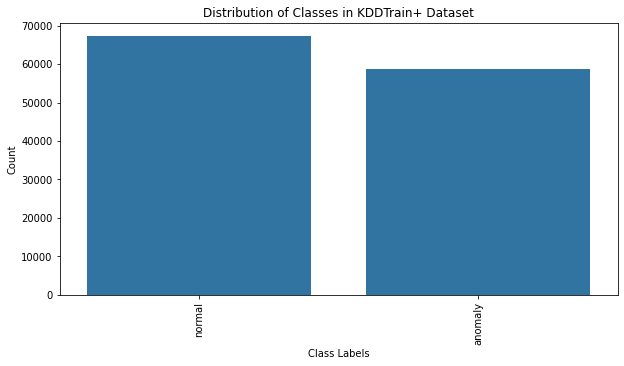

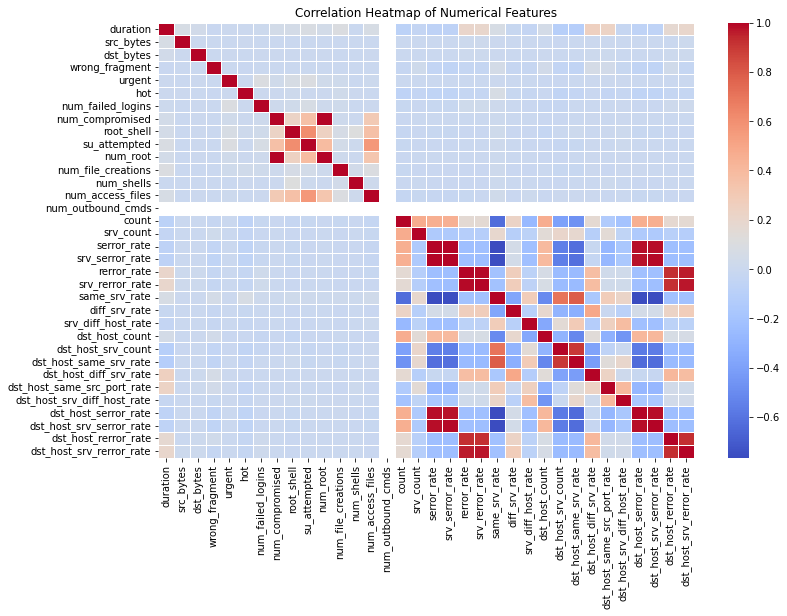

In [7]:
# Display summary statistics for numerical columns
numeric_summary = df.describe()

# Display categorical feature distributions
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_summary = {col: df[col].value_counts() for col in categorical_columns}

# Check class distribution (assuming the last column is the label)
label_column = df.columns[-1]
class_distribution = df[label_column].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Distribution of Classes in KDDTrain+ Dataset")
plt.xticks(rotation=90)
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['float64']).corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [8]:
categorical_cols = ['protocol_type', 'service', 'flag', 'class']
other_object_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in categorical_cols]

# Krok 2: Przekształcenie kolumn kategorycznych za pomocą one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first', dtype=np.int64)
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=df.index)

# Krok 3: Przekształcenie pozostałych kolumn typu object na int64
for col in other_object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int64')

# Krok 4: Usunięcie oryginalnych kolumn kategorycznych i dodanie zakodowanych
df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_df], axis=1)

df['label'] = 1 - df['class_normal']  # Odwrócenie wartości: 0 dla normal, 1 dla anomaly
df = df.drop(columns=['class_normal'])


# Wyświetlenie informacji o zmodyfikowanym DataFrame
print(f"Rozmiar DataFrame: {df.shape}")
print(f"Typy kolumn:\n{df.dtypes}")

Rozmiar DataFrame: (125973, 120)
Typy kolumn:
duration          float64
src_bytes         float64
dst_bytes         float64
land                int64
wrong_fragment    float64
                   ...   
flag_S2             int64
flag_S3             int64
flag_SF             int64
flag_SH             int64
label               int64
Length: 120, dtype: object


In [9]:
print(df.dtypes.value_counts())

int64      86
float64    34
dtype: int64


In [10]:
print("DataFrame summary:")
print("\nMissing values per column:")
print(df.isnull().sum())

# Check label distribution (typically 0: normal, 1: anomaly/fraud)
print("\nLabel distribution:")
print(df['label'].value_counts())

DataFrame summary:

Missing values per column:
duration          0
src_bytes         0
dst_bytes         0
land              0
wrong_fragment    0
                 ..
flag_S2           0
flag_S3           0
flag_SF           0
flag_SH           0
label             0
Length: 120, dtype: int64

Label distribution:
0    67343
1    58630
Name: label, dtype: int64


In [11]:
min_values = df.min()
max_values = df.max()

# Tworzenie DataFrame z wynikami
result = pd.DataFrame({'Min': min_values, 'Max': max_values})

# Wyświetlenie wyników
print(result)

                Min           Max
duration        0.0  4.290800e+04
src_bytes       0.0  1.379964e+09
dst_bytes       0.0  1.309937e+09
land            0.0  1.000000e+00
wrong_fragment  0.0  3.000000e+00
...             ...           ...
flag_S2         0.0  1.000000e+00
flag_S3         0.0  1.000000e+00
flag_SF         0.0  1.000000e+00
flag_SH         0.0  1.000000e+00
label           0.0  1.000000e+00

[120 rows x 2 columns]


In [12]:
print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum().sum()}")

Dataset shape: (125973, 120)

Data types:
duration          float64
src_bytes         float64
dst_bytes         float64
land                int64
wrong_fragment    float64
                   ...   
flag_S2             int64
flag_S3             int64
flag_SF             int64
flag_SH             int64
label               int64
Length: 120, dtype: object

Missing values:
0


In [14]:
float_columns = df.select_dtypes(include=['float64']).columns.tolist()

# Krok 3: Zastosowanie StandardScaler do kolumn float64
scaler = MinMaxScaler()
df[float_columns] = scaler.fit_transform(df[float_columns])

In [16]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values 


In [29]:
normal_indices = np.where(y == 0)[0]
anomaly_indices = np.where(y == 1)[0]

selected_normal_indices = np.random.choice(normal_indices, 5000, replace=False)
anomaly_indices = np.random.choice(anomaly_indices, 5000, replace=False)
selected_indices = np.concatenate([selected_normal_indices, anomaly_indices])

X_selected = X[selected_indices]
y_selected = y[selected_indices]

In [30]:
X_selected.shape

(10000, 119)

In [31]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_selected)

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X_pca)

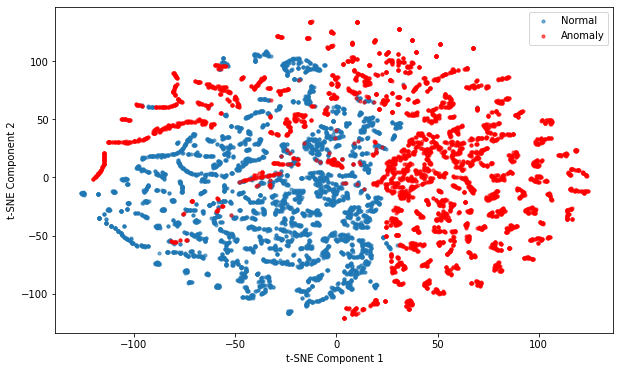

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y_selected == 0, 0], X_tsne[y_selected == 0, 1], label="Normal", alpha=0.6, s=10)
plt.scatter(X_tsne[y_selected == 1, 0], X_tsne[y_selected == 1, 1], label="Anomaly", alpha=0.6, s=10, color='red')

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()